In [1]:
import numpy as np
import pandas as pd
import glob
import os
import json
import anndata

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from dredFISH.Analysis.__init__plots import *
from dredFISH.Analysis import basicu

In [2]:
ddir = "/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/"
!ls $ddir

smrt_X_all_cells.csv
smrt_X_all.npy
smrt_X_all_pnmfS_k24.csv
smrt_X_all_pnmfW_k24.csv
smrt_X_all_y_L3_dpnmfS_k24_mu0.csv
smrt_X_all_y_L3_dpnmfW_k24_mu0.csv
smrt_X_all_y_L3.npy
smrt_X_all_y_L5_dpnmfS_k24_mu0.csv
smrt_X_all_y_L5_dpnmfW_k24_mu0.csv
smrt_X_all_y_L5.npy
smrt_X_subL3n1000_cells.csv
smrt_X_subL3n1000.npy
smrt_X_subL3n1000_pnmfS_k24.csv
smrt_X_subL3n1000_pnmfW_k24.csv
smrt_X_subL3n1000_y_L3_dpnmfS_k24_mu0.csv
smrt_X_subL3n1000_y_L3_dpnmfW_k24_mu0.csv
smrt_X_subL3n1000_y_L3.npy
smrt_X_subL3n100_cells.csv
smrt_X_subL3n100.npy
smrt_X_subL3n100_pnmfS_k24.csv
smrt_X_subL3n100_pnmfW_k24.csv
smrt_X_subL3n100_y_L3_dpnmfS_k24_mu0.csv
smrt_X_subL3n100_y_L3_dpnmfW_k24_mu0.csv
smrt_X_subL3n100_y_L3.npy
smrt_X_subL3n10_cells.csv
smrt_X_subL3n10.npy
smrt_X_subL3n10_pnmfS_k24.csv
smrt_X_subL3n10_pnmfW_k24.csv
smrt_X_subL3n10_y_L3_dpnmfS_k24_mu0.csv
smrt_X_subL3n10_y_L3_dpnmfS_mu1_k24.csv
smrt_X_subL3n10_y_L3_dpnmfW_k24_mu0.csv
smrt_X_subL3n10_y_L3_dpnmfW_mu1_k24.csv
smrt_X_subL3n10_y_L3.npy


# Get data

In [3]:
# analysis metadata
meta_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'
with open(meta_path, 'r') as fh:
    meta = json.load(fh)
    
l3clst_order = meta['l3_clsts'] # get cluster order

In [4]:
# read in data
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_count_matrix_v5.h5ad'
adata = anndata.read(f)#, backed='r')

# get the NN genes
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/10X/genes.npy' 
tenx_genes = np.load(f)
nn_genes = tenx_genes

# get DPNMF results
f = os.path.join(ddir, 'smrt_X_all_pnmfS_k24.csv')
S = pd.read_csv(f, index_col=0)

f = os.path.join(ddir, 'smrt_X_all_pnmfW_k24.csv')
W = pd.read_csv(f, index_col=0)

f = os.path.join(ddir, 'smrt_X_all_cells.csv')
cells = pd.read_csv(f, index_col=0)['0'].values
print(S.shape, W.shape, cells.shape)

# get annotations
genes = nn_genes

# get the data right
adatasub = adata[cells, genes]
cells_annot = adatasub.obs

(73347, 24) (10861, 24) (73347,)


# Generate matrices 

In [5]:
def normalize_w(W, num_tp=90000):
    """Normalize the matrix W from DPNMF
    - scale 
    - integerize
    - remove genes with no weights
    """
    # scale
    Wn = W/(W.sum().sum())*num_tp
    # integerize 
    Wn = (Wn+0.5).astype(int)
    # remove genes with no weights
    nonzero_cond = Wn.sum(axis=1)>0  
    
    Wn_slim = Wn.loc[nonzero_cond]
    
    print(f"Total num probes: {Wn.sum().sum():,}")
    print(f"Total num genes: {nonzero_cond.sum():,}")
    return Wn, Wn_slim, nonzero_cond

In [6]:
# basis matrix
Wn, Wn_slim, Wn_nzcond = normalize_w(W)

# score matrix (theory)
Sc, clsts = basicu.group_sum(S, cells_annot['subclass_label'].values, 
                             group_order=l3clst_order)
Scn = basicu.zscore(Sc, allow_nan=False, axis=0)

# score matrix (practice)
Sp = adatasub.X.toarray().dot(Wn)
Spc, clsts = basicu.group_sum(Sp, cells_annot['subclass_label'].values, 
                              group_order=l3clst_order)
Spcn = basicu.zscore(Spc, allow_nan=False, axis=0)

Total num probes: 88,317
Total num genes: 7,137


# Viz

In [7]:
def plot_W(Wn_slim, ax, reorder_genes=True, style='v'):
    Wn_slim = np.array(Wn_slim)
    if reorder_genes:
        _mat, _row, _col = basicu.diag_matrix_rows(Wn_slim)
    else:
        _mat = Wn_slim
    m, n = _mat.shape
    
    if style == 'v':
        cbar_kws = dict(shrink=0.5, label='Mean num probes')
    elif style == 'h':
        cbar_kws = dict(shrink=0.8, label='Mean num probes', orientation='horizontal', pad=0.05)

    sns.heatmap(
                pd.DataFrame(_mat), 
                cmap='rocket_r',
                ax=ax, 
                cbar_kws=cbar_kws,
                rasterized=True,
                norm=matplotlib.colors.LogNorm(),
               )
    ax.set_xlabel('Basis')
    ax.set_ylabel('Genes')

    ax.set_xticks([n])
    ax.text(n, m, n, ha='center', va='top')

    ax.set_yticks([m])
    ax.text(0, m, m, ha='right', va='center')
    
    return _mat, _row

def plot_Sc(Sc, ax, style='v', **kwargs):
    """
    """
    m, n = Sc.shape
    
    if style == 'v':
        cbar_kws = dict(shrink=0.5, label='Mean num probes')
    elif style == 'h':
        cbar_kws = dict(shrink=0.8, label='Mean num probes', orientation='horizontal', pad=0.05)
    
    sns.heatmap(Sc, 
                xticklabels=5,
                cmap='coolwarm', 
                norm=matplotlib.colors.LogNorm(),
                cbar_kws=cbar_kws,
                ax=ax,
                **kwargs,
               )
    # ax.set_xticks([n])
    # ax.text(n, m, n, ha='center', va='top')
    
def plot_Scn(Scn, ax, style='v', **kwargs):    
    """
    """
    m, n = Scn.shape
    
    if style == 'v':
        cbar_kws = dict(shrink=0.5, label='Zscored mean num probes')
    elif style == 'h':
        cbar_kws = dict(shrink=0.8, label='Zscored mean num probes', orientation='horizontal', pad=0.05)
        
    sns.heatmap(Scn, 
                xticklabels=5,
                cmap='coolwarm', 
                cbar_kws=cbar_kws,
                center=0,
                vmax=3,
                vmin=-3,
                ax=ax,
                **kwargs,
               )
    # ax.set_xticks([n])
    # ax.text(n, m, n, ha='center', va='top')
    
def plot_all_mats(Wn_slim, Sc, Spc, Scn, Spcn, title=""):
    """
    """
    with sns.axes_style('white'):
        fig, axs = plt.subplots(1, 5, figsize=(6*5,16))
        ax = axs[0]
        plot_W(Wn_slim, ax, style='h')
        ax.set_title(title)

        ax = axs[1]
        plot_Sc(Sc, ax, style='h', yticklabels=False)
        ax.set_title('Z (theory)')
        ax.set_ylabel('Cell types')

        ax = axs[2]
        plot_Sc(Spc, ax, style='h', yticklabels=False)
        ax.set_title('Z (corrected)')

        ax = axs[3]
        plot_Scn(Scn, ax, style='h', yticklabels=False)
        ax.set_title('Z (theory) normed')

        ax = axs[4]
        plot_Scn(Spcn, ax, style='h', yticklabels=l3clst_order)
        ax.set_title('Z (corrected) normed')
        ax.yaxis.tick_right()
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

        fig.subplots_adjust(wspace=0.1)
        plt.show()

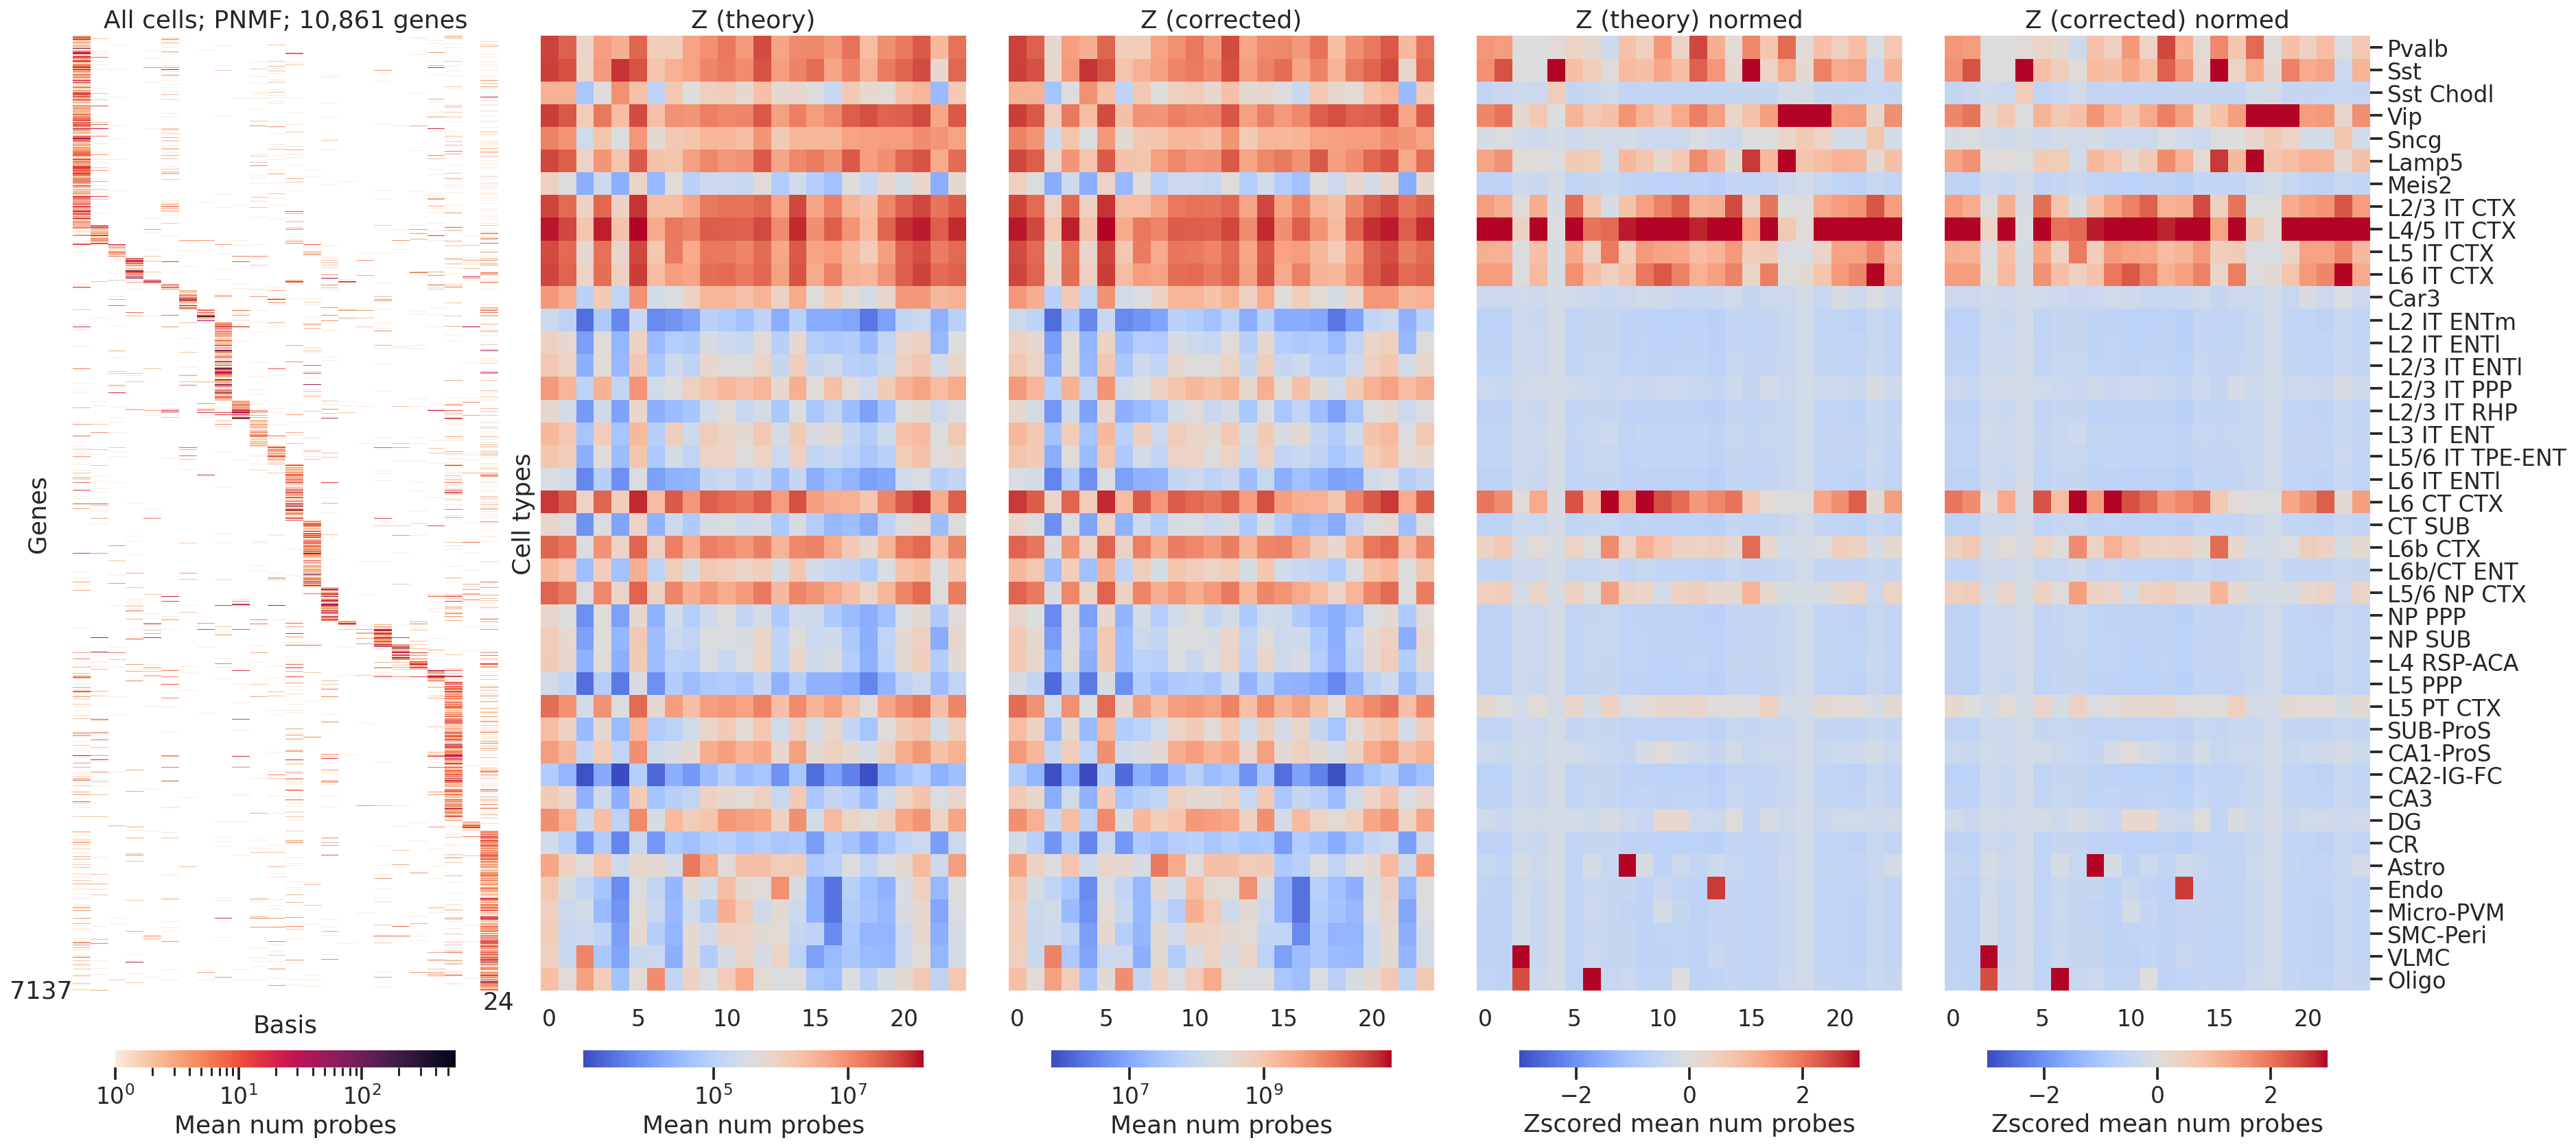

In [8]:
title = f"All cells; PNMF; {len(genes):,} genes"
plot_all_mats(Wn_slim, Sc, Spc, Scn, Spcn, title=title)